In [1]:
import numpy as np
import scipy.io.wavfile as wav
import numpy, os, csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from scipy.io import loadmat 
import math
import pandas as pd

## Functions

## Getting and Saving RTs for a single subject

In [3]:
subject = 'R3279'
word_list = 'A1'

In [2]:
#--- Based on Jarne (2017) "Simple empirical algorithm to obtain signal envelope in three steps"
def _get_envelope(signal, fs=44100, N=200, cutoff=2000):
    '''
    signal: input wav (numpy.ndarray)
    fs: sampling frequency
    N: number of samples per chunk (in part (2))
    cutoff: LPF cutoff, the smaller the cuttoff the stronger the filter. (tweek this).
    '''
    # 1) Take the absolute value of the signal
    abs_signal = abs(signal)
    # 2) Seperate into samples of N, and get peak value of each sample.
    chunked_signal = [abs_signal[i:i+N] for i in range(0, len(abs_signal), N)]
    new_signal = []
    for chunk in chunked_signal: #Then for each chunk, replace all values by max value
        max_value = np.max(chunk)
        new_chunk = [max_value for i in range(len(chunk))]
        new_signal.append(new_chunk)
    # new_signal = np.array(new_signal).flatten()
    new_signal = np.array([item for sublist in new_signal for item in sublist]) # flatten list of lists
    # 3) LPF the new_signal (the envelope, not the original signal)
    def FilterSignal(signal_in, fs, cutoff):
        B, A = butter(1, cutoff / (fs / 2.0), btype='low')
        filtered_signal = filtfilt(B, A, signal_in, axis=0)
        return filtered_signal
    filteredSignal = FilterSignal(new_signal, fs, cutoff)

    return filteredSignal


# Note The threshold depends also on the input volume set on the computer
def _get_voice_onset(signal, threshold = 8000000, fs=44100, min_time=300):
    '''
    signal : numpy.ndarray
             signal in. Should be the envelope of the raw signal for accurate results
    threshold : int
                Amplitude threshold for voice onset.
                (Threshold = 200 with NYUAD MEG mic at 75% input volume seems to work well)
    fs : int
         Sampling frequency
    min_time : int (ms)
             Time in ms after the threshold is crossed used to calculate
              the median amplitude and decide if it was random burst of noise
              or speech onset.
    '''

    n_above_thresh = int(fs/min_time) # convert time above threshold to number of samples.

    indices_onset = np.where(signal >= threshold)[0] # All indices above threshold
    # Next, find the first index that where the MEDIAN stays above threshold for the next 10ms
    # Not using the MEAN because sensitive to a single extreme value
    # Note 44.1 points per millesconds (for fs=44100)
    # 10ms = 441 points
    for i in indices_onset:
        median_mintime = np.median(np.abs(signal[i:i+n_above_thresh])) # median value in the timewindow of length min_time
        if median_mintime >= threshold:
            idx_onset = i
            onset_time = idx_onset / float(fs) * 1000.0

            return idx_onset, onset_time
    return np.nan, np.nan # if no point exceeds the threshold.
                          # Return "None" instead of None in order to be able to append it to a list later on



# LPF function: used in _get_envelope() but here for seperate use.
def FilterSignal(signal_in, fs=44100, cutoff=200):
    '''
    signal_in : numpy.ndarray
                Input .wav signal
    fs : int
         Sampling frequency
    cutoff : int
             LPF cutoff (200 works well with NYUAD MEG mic)
    '''
    B, A = butter(1, cutoff / (fs / 2.0), btype='low')
    filtered_signal = filtfilt(B, A, signal_in, axis=0)
    return filtered_signal



def auto_utterance_times(signal, fs, threshold=8000000, min_time=300):
    '''
    Automatically get utterance times.
    Returns idx and rt (ms)
    signal, fs : np.array, int
                 fs, signal = wav.read(file_in)
    threshold, min_time : see _get_voice_onset()
    Returns
    ---------
    idx : index of utterance time
    rt : in milliseconds
    '''
    flt_signal = FilterSignal(signal,fs=fs)
    env = _get_envelope(flt_signal,fs=fs)
    idx, rt = _get_voice_onset(env,fs=fs, threshold=threshold, min_time=min_time)

    return idx, rt


def plot_utterance_time(signal, fs, rt, title=None, show=True, savefig=None):
    '''
    signal, fs : np.array, int
                 fs, signal = wav.read(file_in)
    rt : float
         rt in milliseconds
    show : bool
           Toggle show figure
    savefig : None, str
              Path to save figure. If None, figure is not saved
    '''

    # Creating X axis, in miliiseconds
    N_samples = len(signal)
    len_signal_ms = len(signal)/fs*1000
    times = np.arange(0,len_signal_ms,1.0/fs*1000)

    if len(times) == len(signal) + 1:
        times = times[:-1]

    #plotting
    fig, ax = plt.subplots(figsize=((18,5)))
    ax.plot(times, signal, color='b')
    ax.axvline(rt, color='r')
    ax.set_title(title)

    if savefig:
        plt.savefig(savefig)

    if show:
        plt.show()

    return fig, ax



def auto_utterance_times_batch(wav_paths, output_txt=None, plots_dir=None, threshold=8000000, min_time=300):
    '''
    Automatically get utterance times. Returns list of indices and rts (ms).
    Option to output results to file.

    wav_paths : list paths to .wav files

    threshold, min_time : see _get_voice_onset()

    output_txt : None, str
                 Path to txt file output

    plots_dir : None, str
                Directory to plot waveform and utterance times. If none, no plotting done.
    Returns
    ---------
    indices : indices of utterance times
    rts : in milliseconds
    '''


    rts_out = []
    idx_out = []

    for v in tqdm(wav_paths):
        fs, signal = wav.read(v)
        flt_signal = FilterSignal(signal,fs=fs)
        env = _get_envelope(flt_signal,fs=fs)
        idx, rt = _get_voice_onset(env,fs=fs, threshold=threshold, min_time=min_time)
        rts_out.append(rt)
        idx_out.append(idx)

        if plots_dir:
            title = os.path.basename(v).replace('.wav','')
            fig_path = os.path.join(plots_dir, title+'.jpg')
            plot_utterance_time(signal, fs, rt, title=title, show=False, savefig=fig_path)
            plt.close()

    if output_txt:
        f = open(output_txt,'w')
        for r in rts_out:
            f.write('%s\n'%r)
        f.close()

    return idx_out, rts_out




def semi_auto_utterance_times(wav_paths, dir_out, threshold=8000000, min_time=300, plot_filtered=True):
    '''
    Automatically detects utterance times and plots them, allowing to manually edit the prediction.
    To edit prediction, double click on plot to move the vertical line. Press enter on terminal to go to the next plot.
    Figures are saved to file.

    wav_paths : list paths to .wav files

    dir_out : str (directory)
            Output directory

    threshold, min_time : see _get_voice_onset()

    plot_filtered : bool, if true plots filtered signal, else plots the raw signal

    Returns
    ---------
    rts : in milliseconds

    '''

    plt.ion()
    def onpick(event):
        if event.dblclick:
            manual_rts.append(event.xdata) #manual_rts is a variable defined in below semi_auto_utterance_times. Not the best way to write this.
            L =  ax.axvline(x=event.xdata, color='orange')
            fig.canvas.draw()
        elif event.button == 3:
            plt.close()
            fig.canvas.mpl_disconnect(cid)
            return

    rts_out = []

    nb = 0 #keep count
    for v in wav_paths:
        nb+=1
        print('#%s'%nb, v)
        # auto fetch RT
        fs, signal = wav.read(v)
        flt_signal = FilterSignal(signal)
        env = _get_envelope(flt_signal)
        rt_auto = _get_voice_onset(env, threshold=threshold, min_time=min_time)
        print("rt auto ", rt_auto)

        # Creating X axis, in miliiseconds
        N_samples = len(signal)
        len_signal_ms = len(signal)/fs*1000
        X_axis = np.arange(0,len_signal_ms,1.0/fs*1000)

        # plot and fix rt
        manual_rts = [] # DEFINED HERE manual_rts
        fig, ax = plt.subplots(figsize=((18,5)))
        plt.title(v)

        if plot_filtered:
            ax.plot(X_axis, flt_signal, color='b')
        else:
            ax.plot(X_axis, signal, color='b')

        if rt_auto:
            ax.axvline(rt_auto[1], color='r')
        cid = fig.canvas.mpl_connect('button_press_event', onpick)
        input('press enter to continue...') #pauses to wait for cid to finish

        if len(manual_rts) > 0:
            # rt = (manual_rts[-1][0], manual_rts[-1][1]*1000) #Keep idx as is, convert rt to milliseconds. commented out because idx=milliseconds now.
            rt = manual_rts[-1]
        else:
            rt = rt_auto[1] #convert to milliseconds

        print('final rt ', rt)
        print('--------------------')
        rts_out.append(rt)

        fig_outpath = dir_out + os.path.basename(v).replace('.wav','.jpg')
        plt.savefig(fig_outpath)
        plt.close()

    return rts_out

def get_file_names(folder_path):
  """
  Returns a list of all file names in the specified folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    A list of strings, where each string is a file name.
  """
  try:
    return [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  except FileNotFoundError:
    return f"Error: Folder not found at path: {folder_path}"


def get_RTs(folder_path, word_list):
    file_names = get_file_names(folder_path)
    file_names.sort()

    if file_names[0] == '.DS_Store':
        file_names = file_names[1:]

    response_times=[]
    for i in file_names:
        file = folder_path+'/'+i
        fs, signal = wav.read(file)
        idx, rt = auto_utterance_times(signal, fs)
        response_times.append(rt)
        print(i)
        plot_utterance_time(signal, fs, rt)

    if word_list == "A1":
        titles = loadmat(r"/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/StimComputer/ListA1.mat")
    elif word_list == "B1":
        titles = loadmat(r"/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/StimComputer/ListB1.mat")
    elif word_list == "A2":
        titles = loadmat(r"/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/StimComputer/ListA2.mat")
    elif word_list == "B2":
        titles = loadmat(r"/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/StimComputer/ListB2.mat")

    else:
        return "Invalid word list"

    triggers = [i[0] for i in titles['wordTriggers']]

    if len(response_times) == 154:
        response_times = response_times[4:]

    rep = []
    no_rep = []
    dropped_trials = []
    total = []
    for i in range(len(response_times)):
        if math.isnan(response_times[i]) == True:
            dropped_trials.append(i)
        elif triggers[i] == 130:
            rep.append(response_times[i])
        else:
            no_rep.append(response_times[i])
        total.append(response_times[i])

    # for i in dropped_trials:
    #     del response_times[i]
    #     del triggers[i]

    return total, triggers, rep, no_rep

000bee.wav


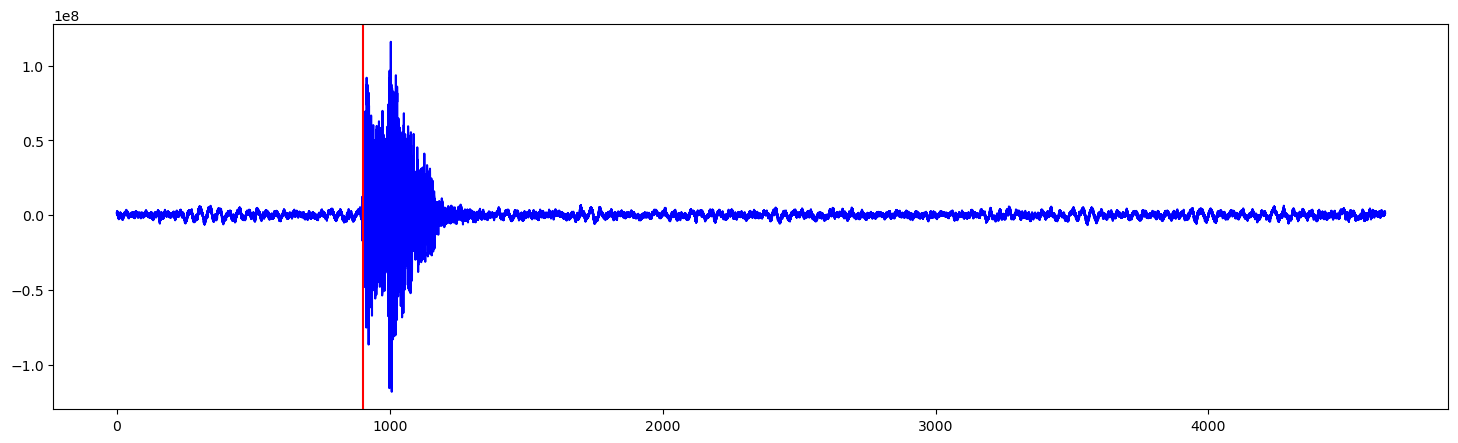

001trolley.wav


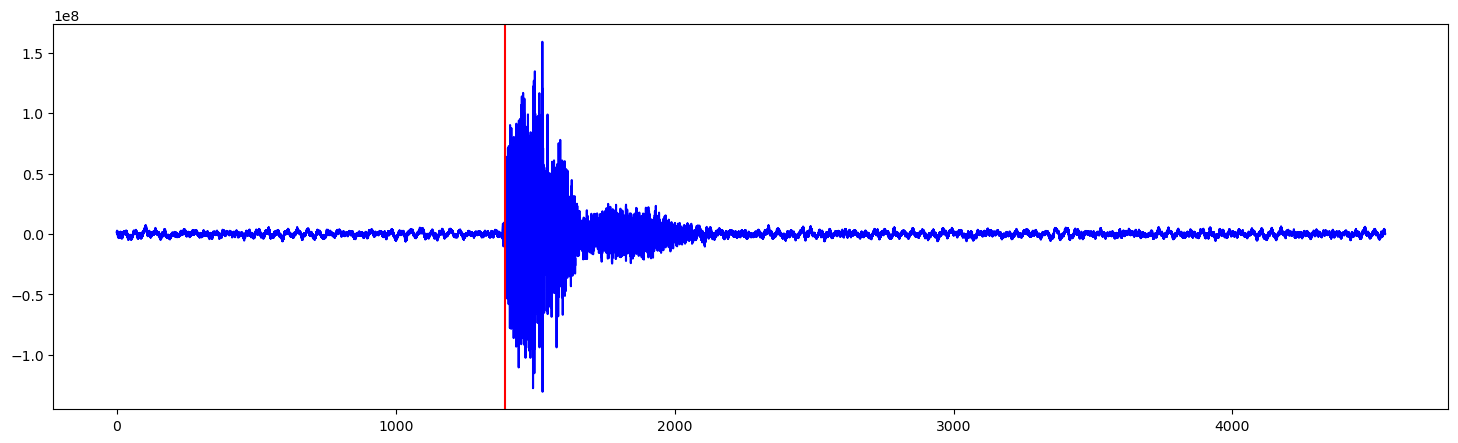

002seatbelt.wav


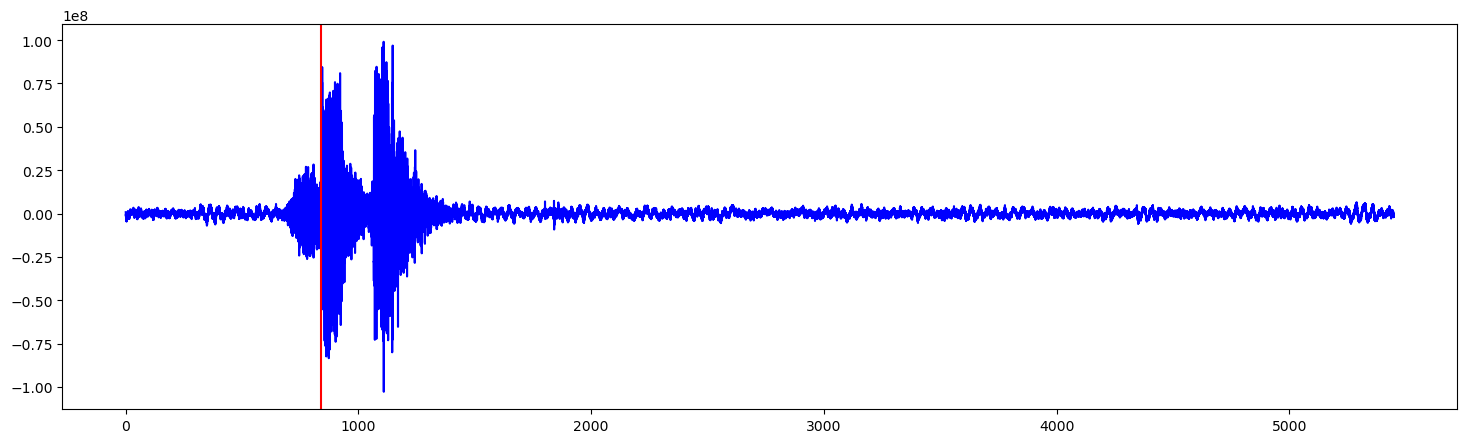

003horse.wav


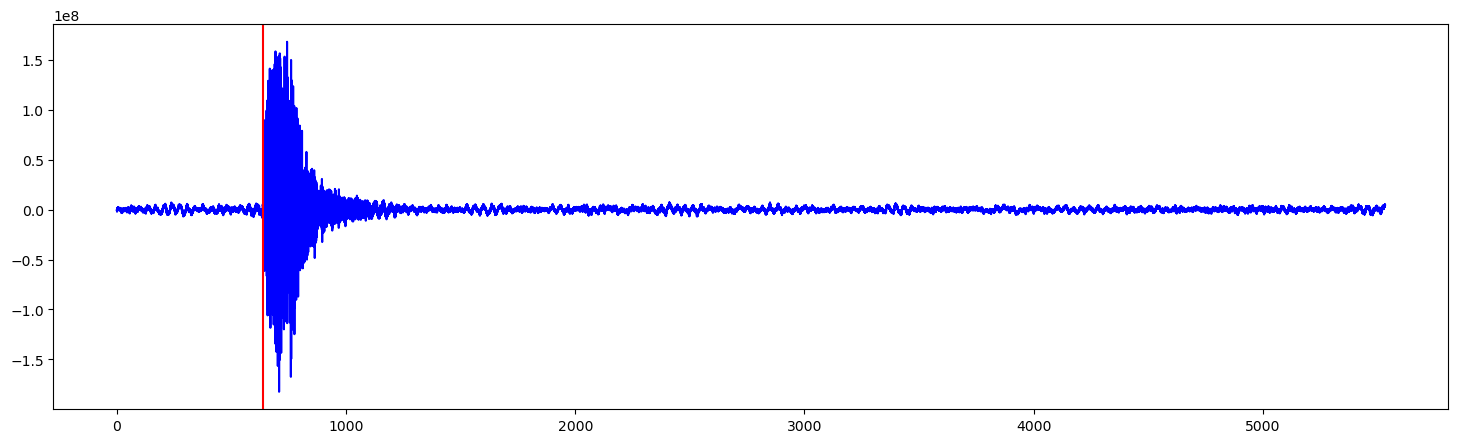

004bathtub.wav


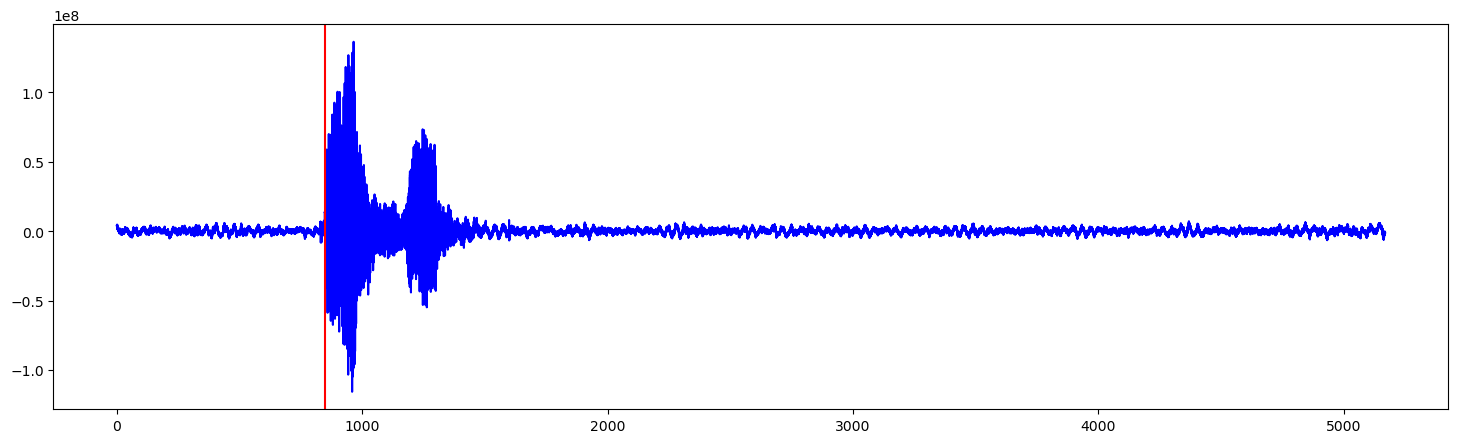

005popcorn.wav


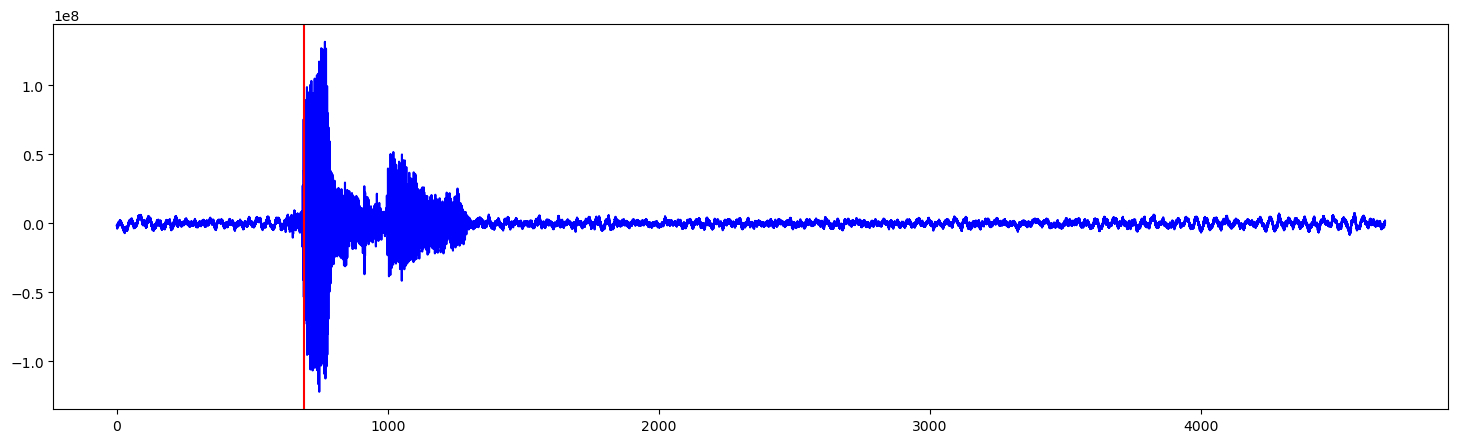

006beet.wav


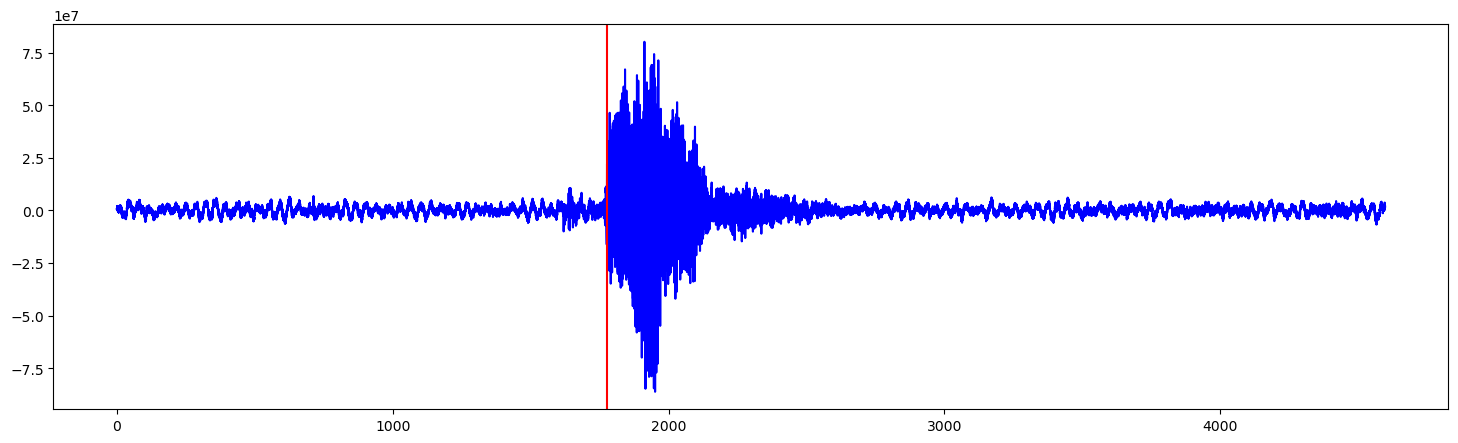

007spatula.wav


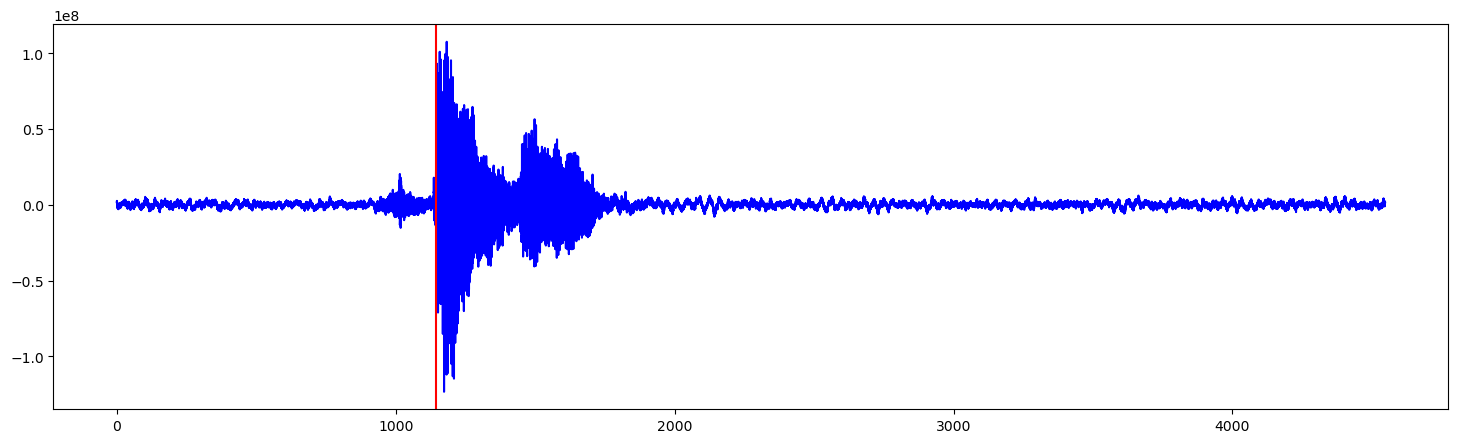

008swing.wav


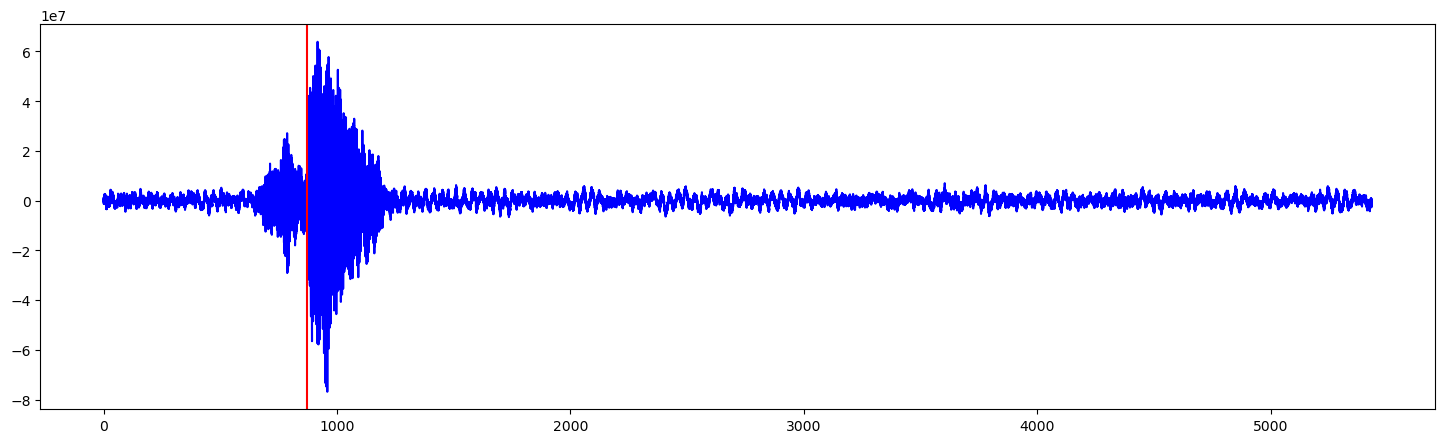

009truck.wav


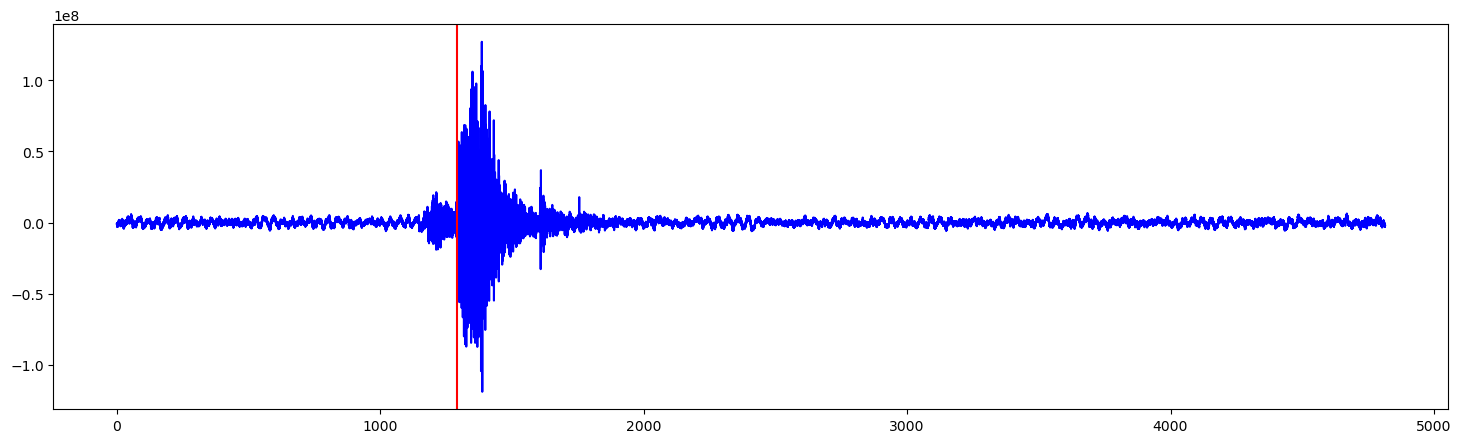

010keyboard.wav


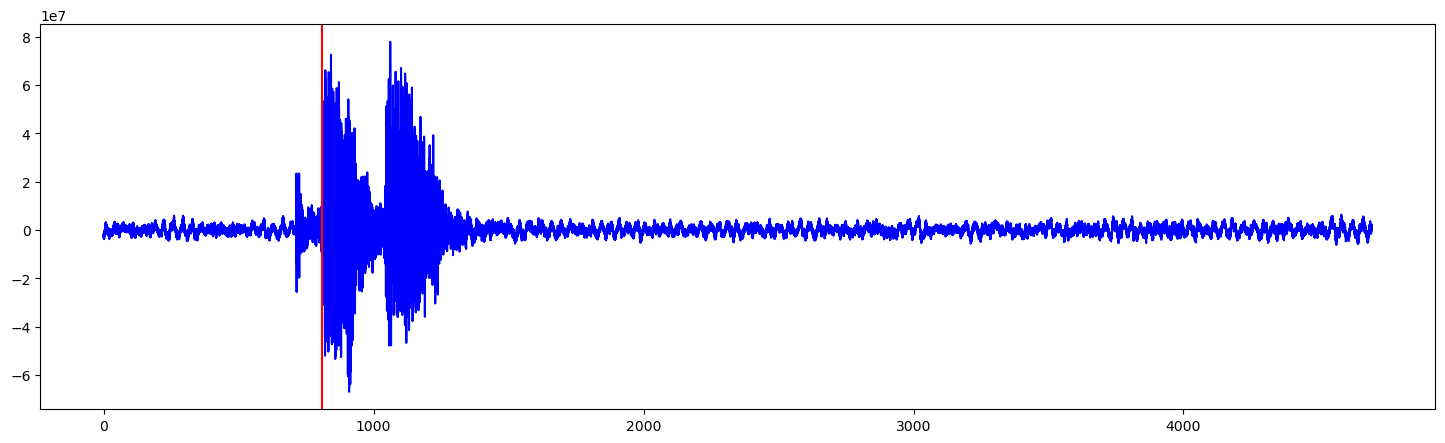

011ball.wav


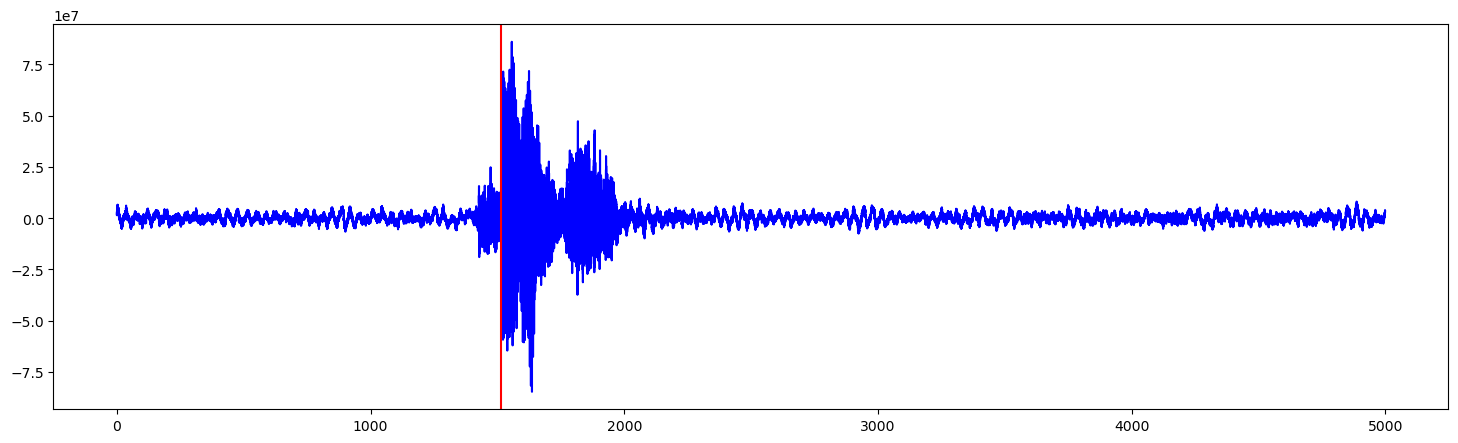

012makeup.wav


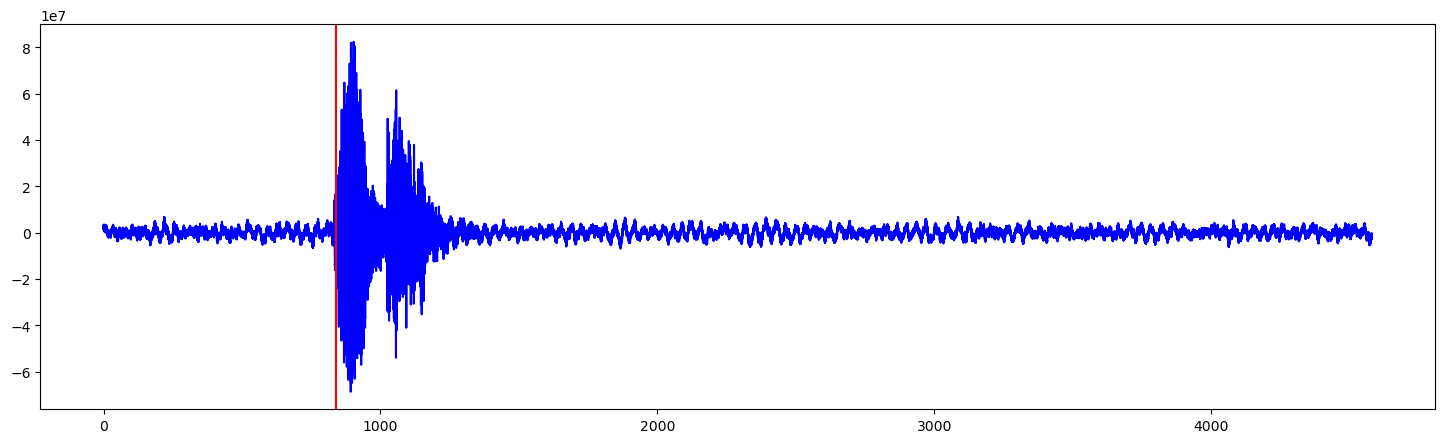

013coffee.wav


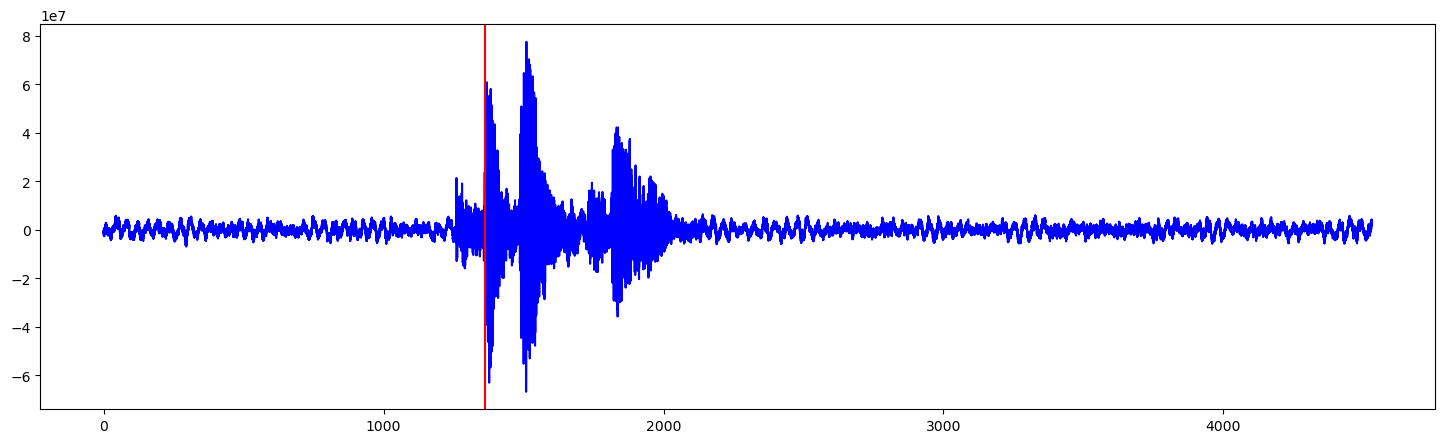

014zucchini.wav


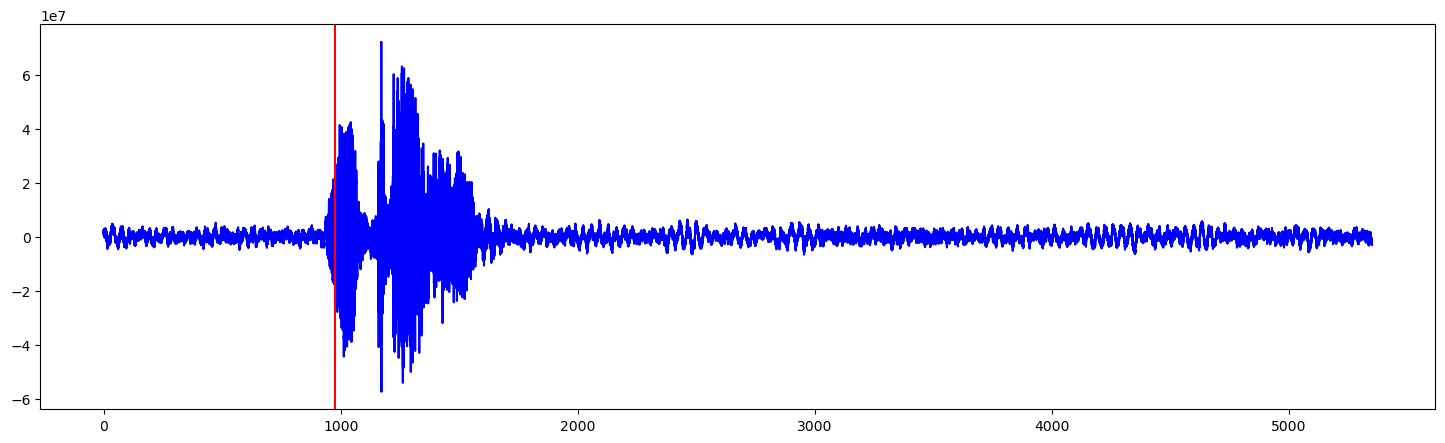

015shield.wav


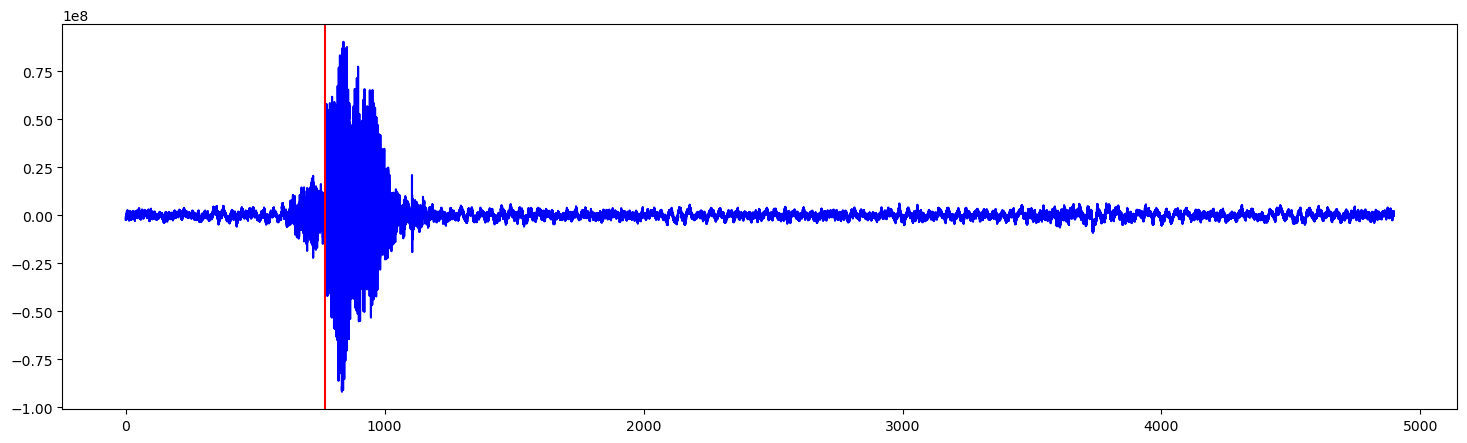

016rug.wav


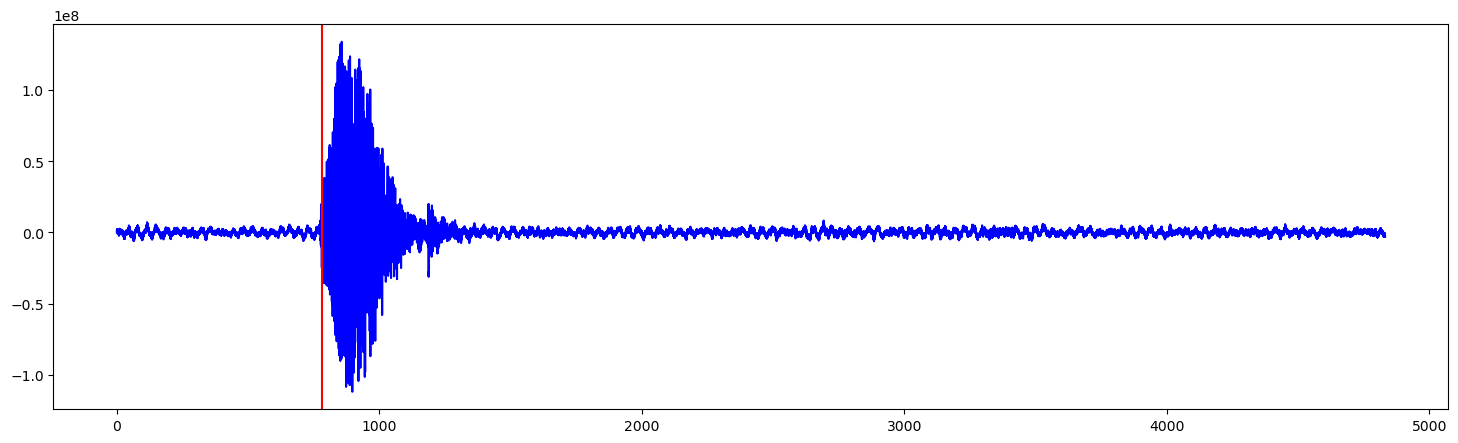

017lime.wav


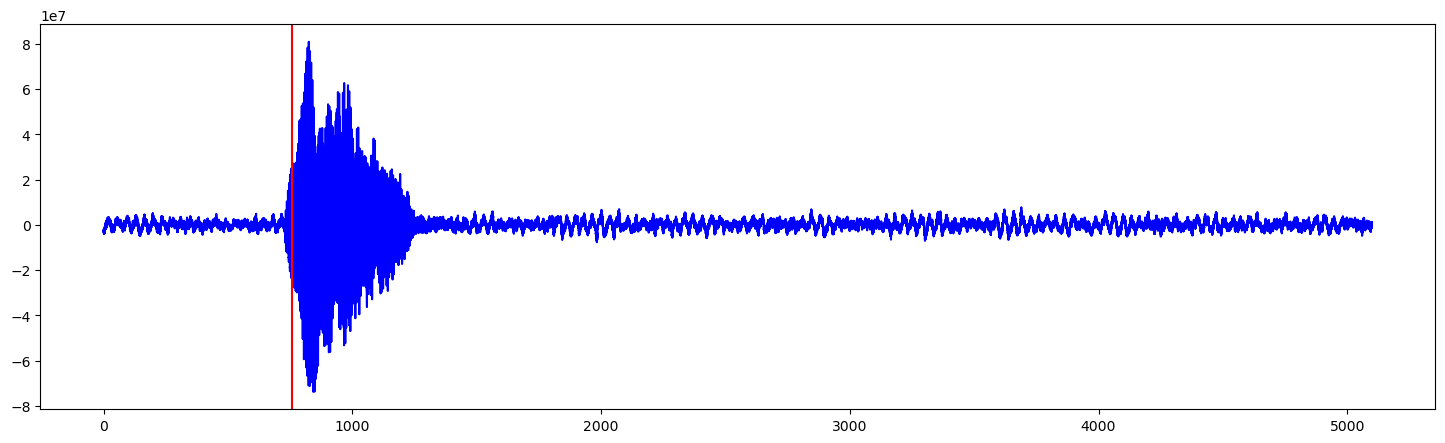

018spinach.wav


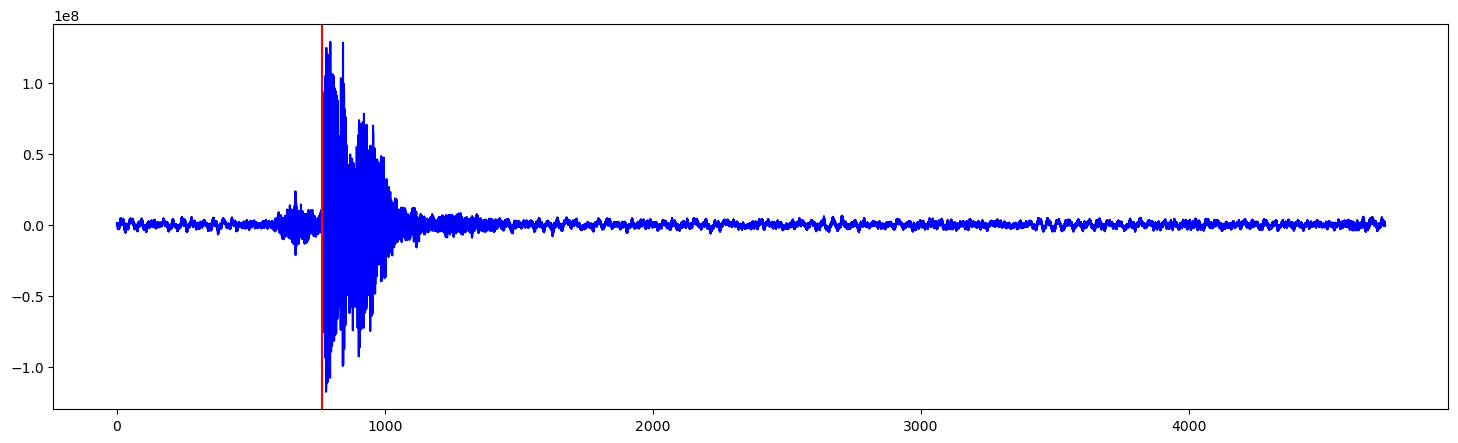

019broom.wav


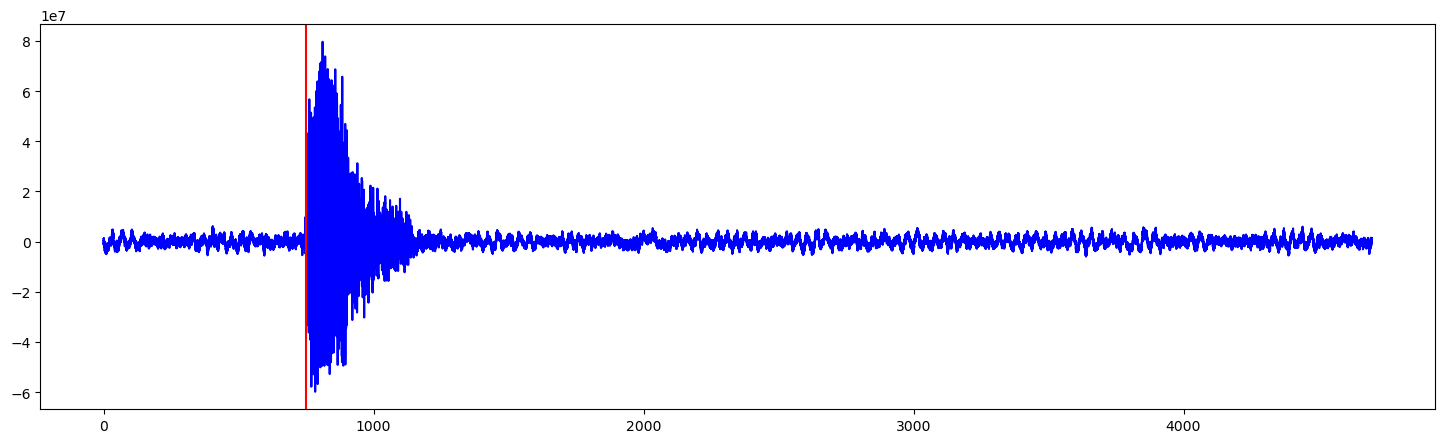

020corkscrew.wav


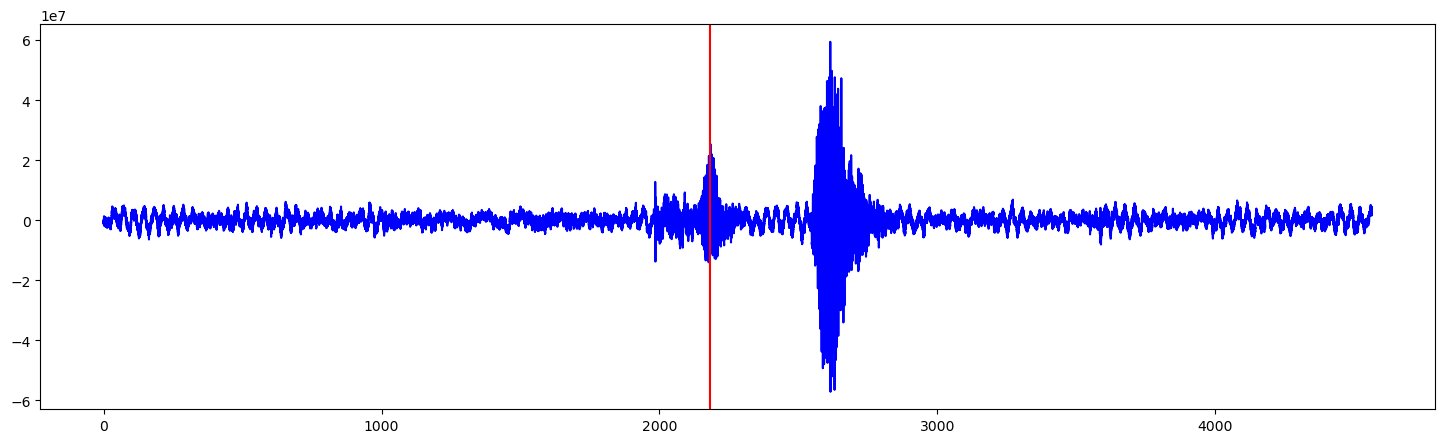

021spaghetti.wav


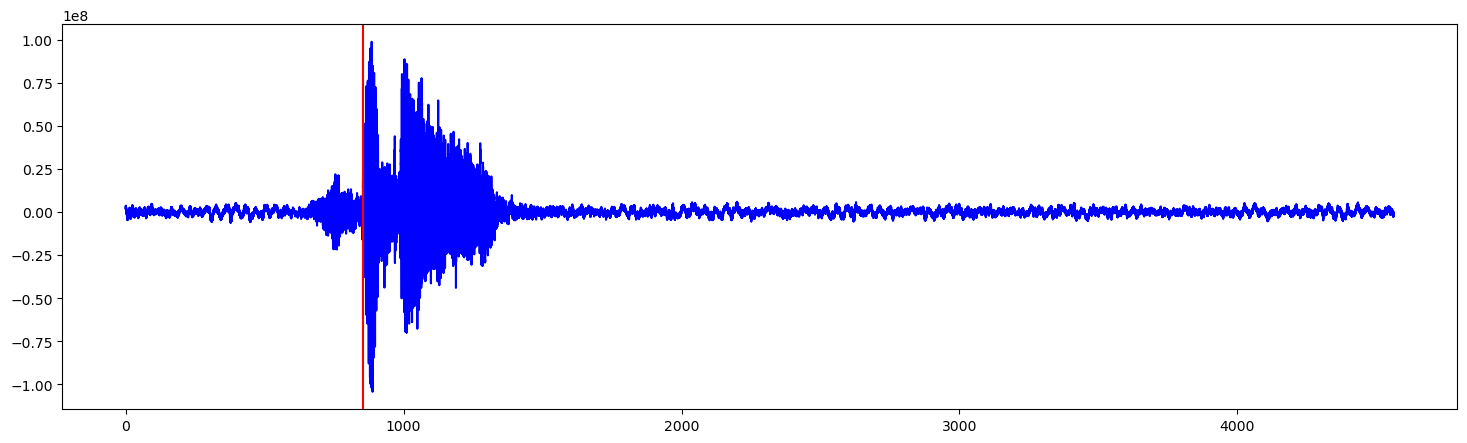

022perfume.wav


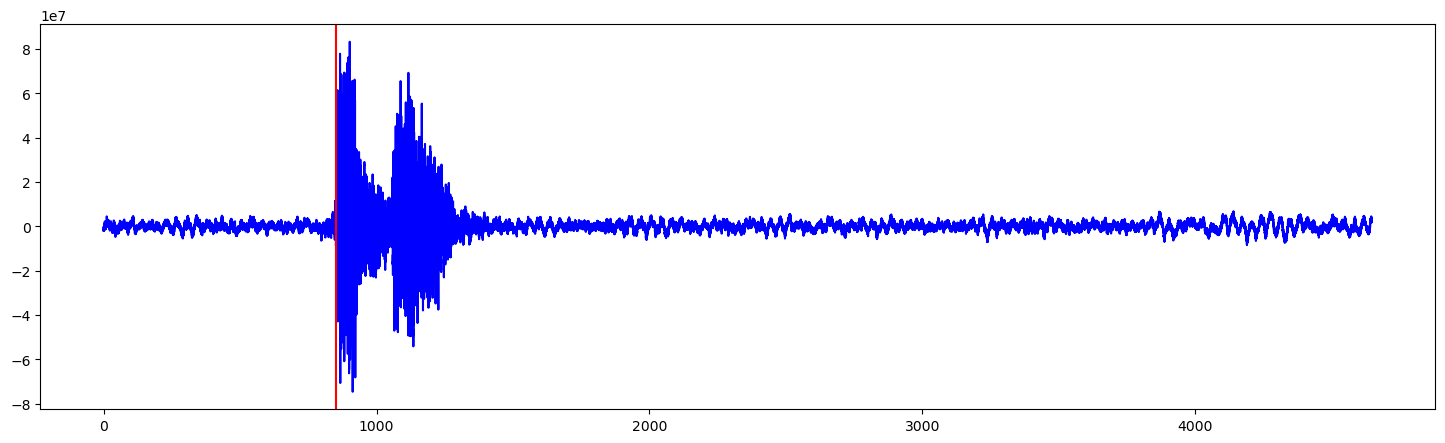

023lighthouse.wav


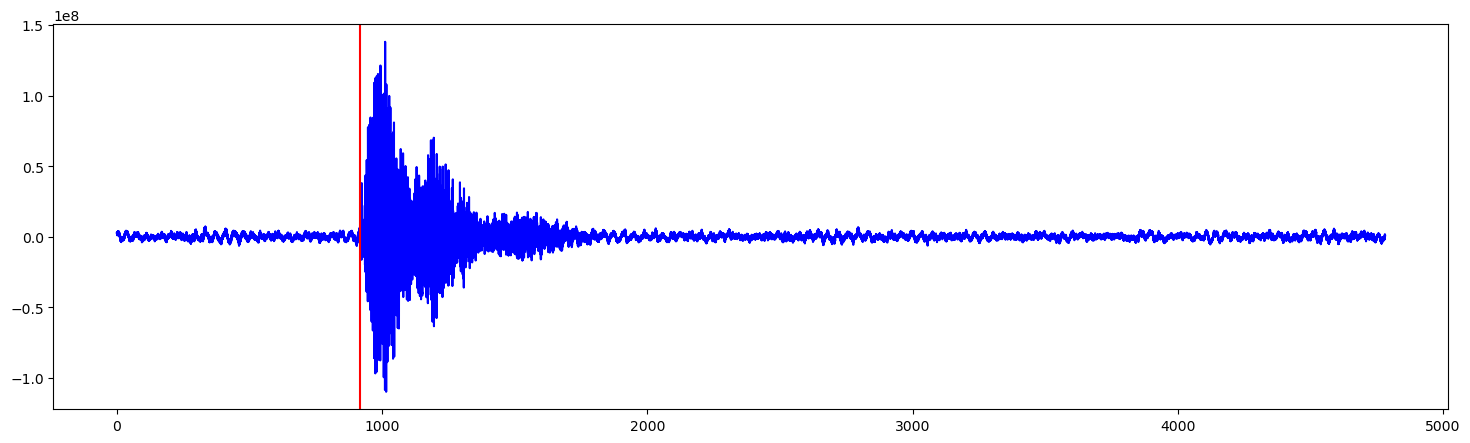

024pocket.wav


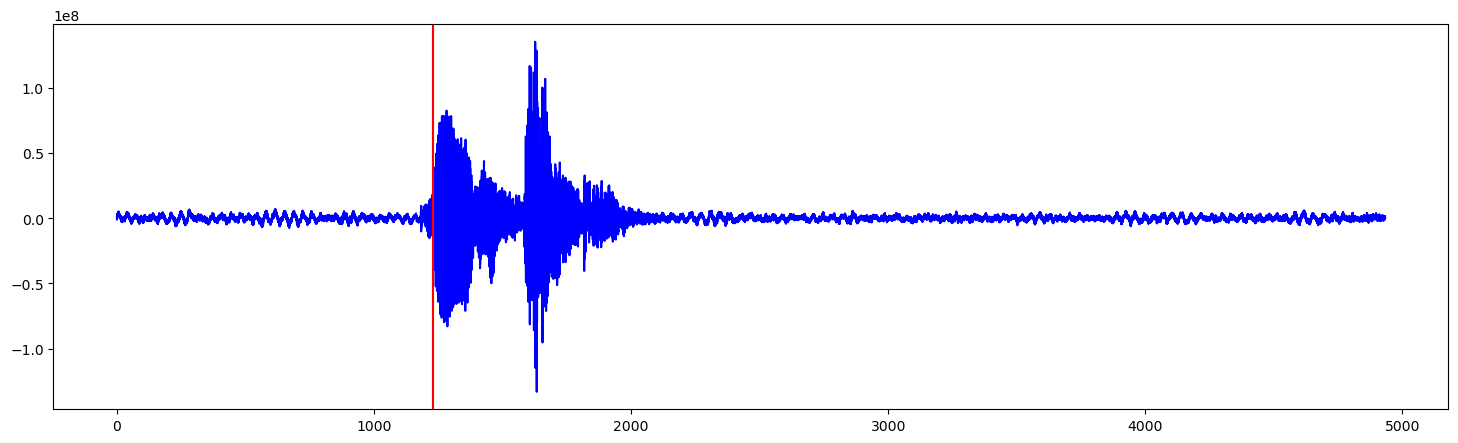

025battery.wav


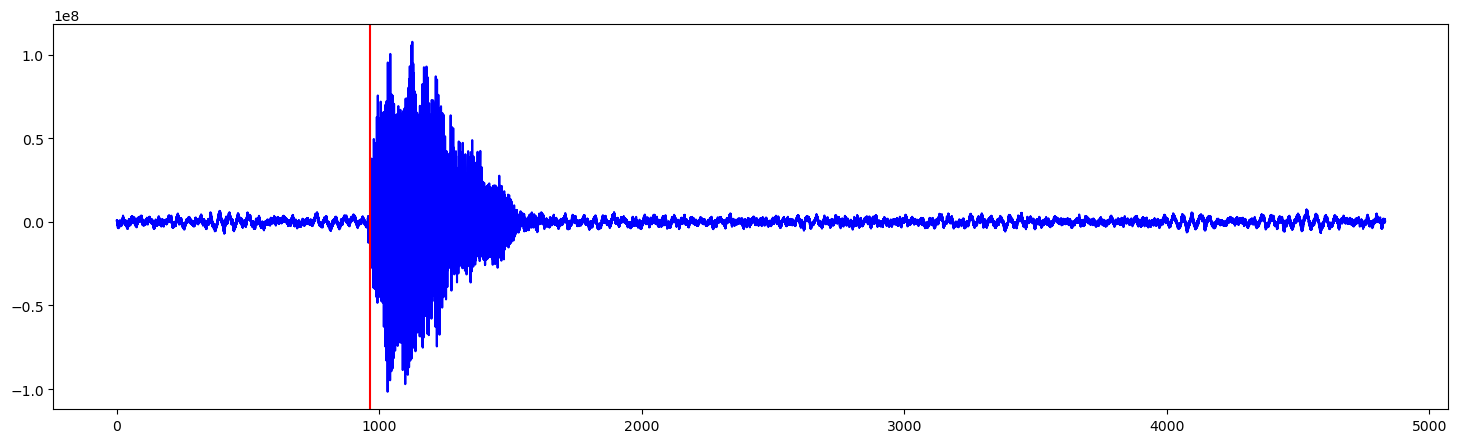

026tag.wav


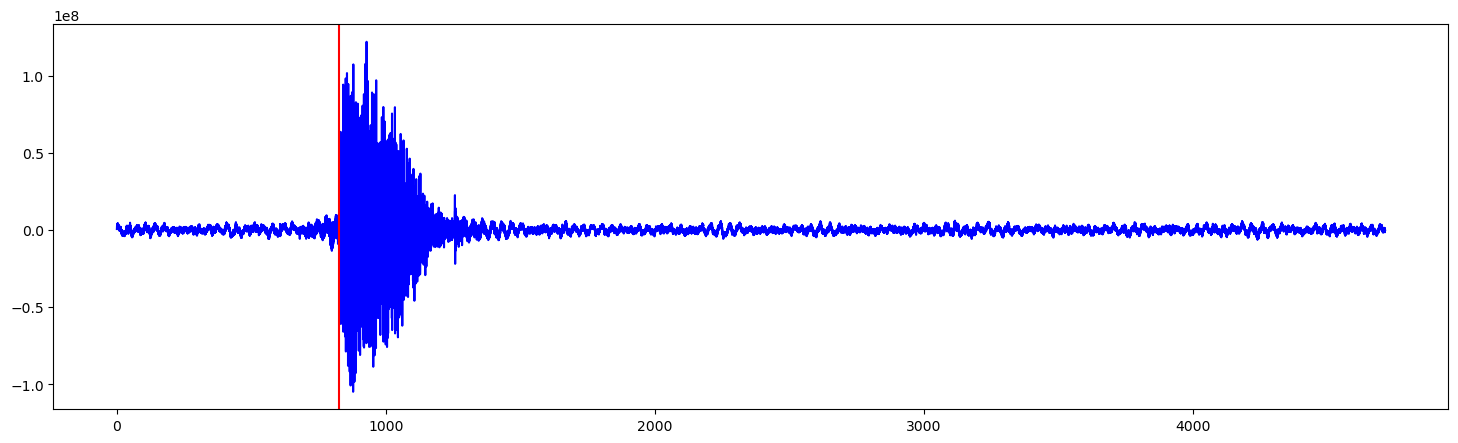

027bubble.wav


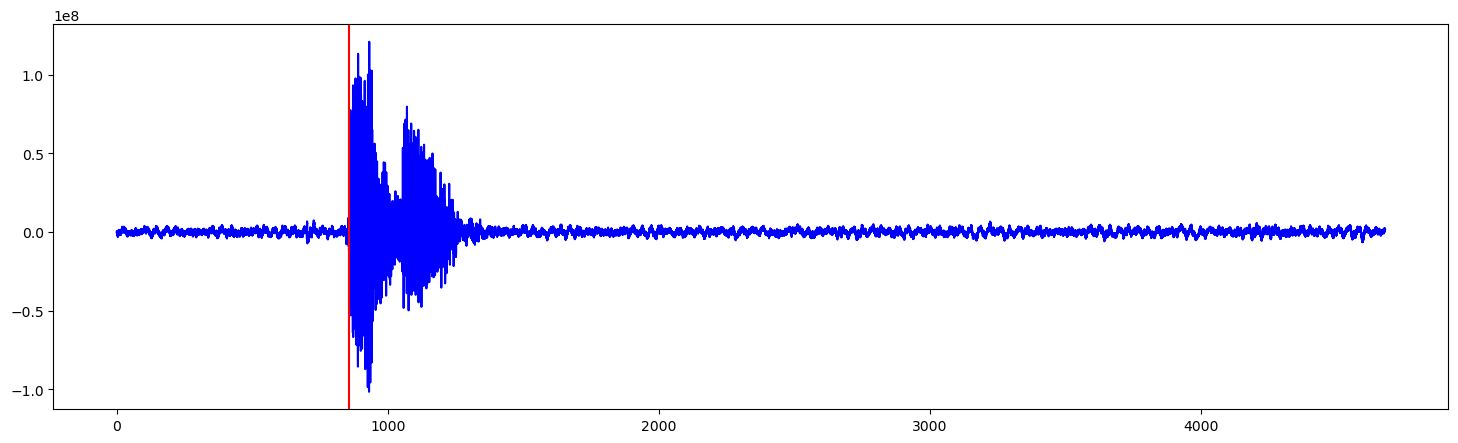

028staple.wav


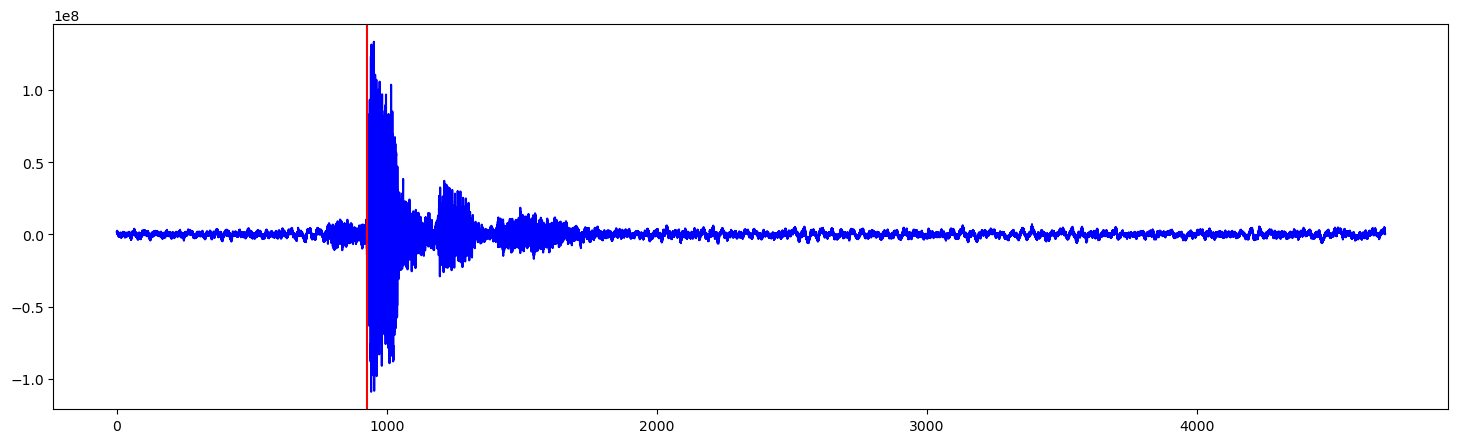

029fan.wav


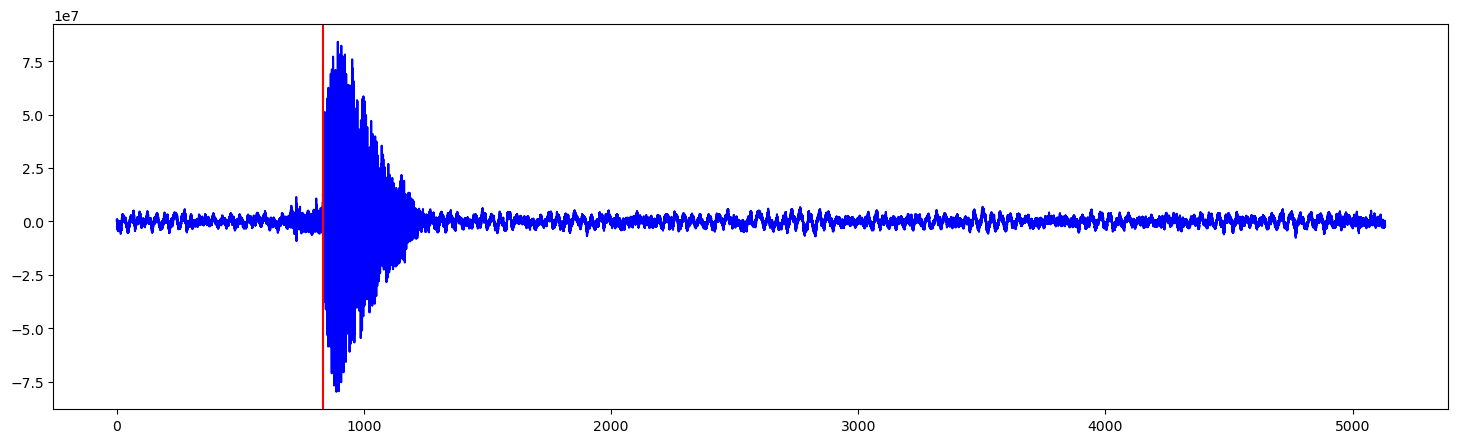

030seahorse.wav


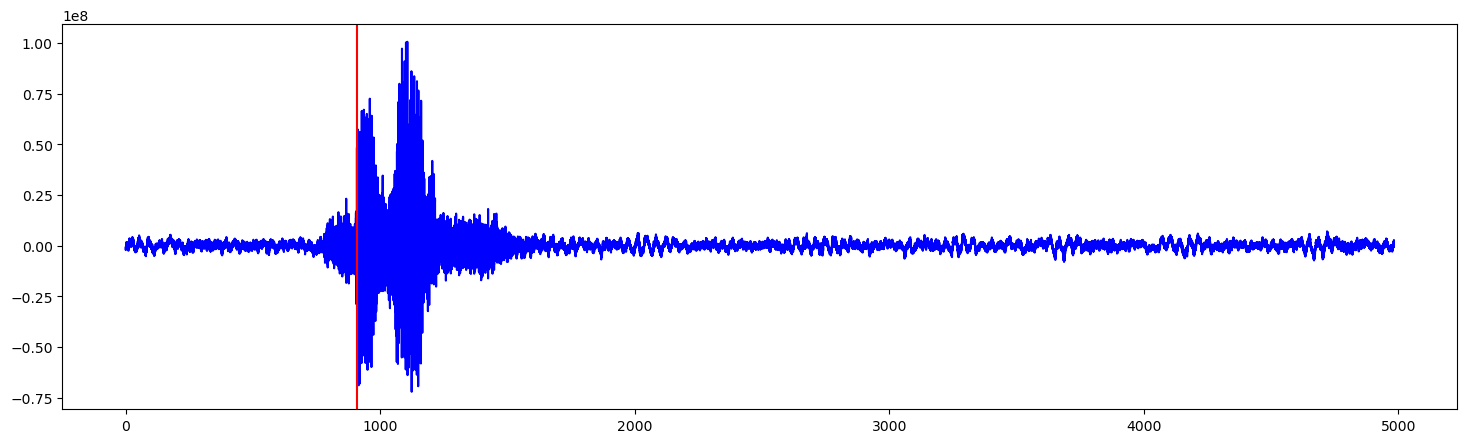

031octopus.wav


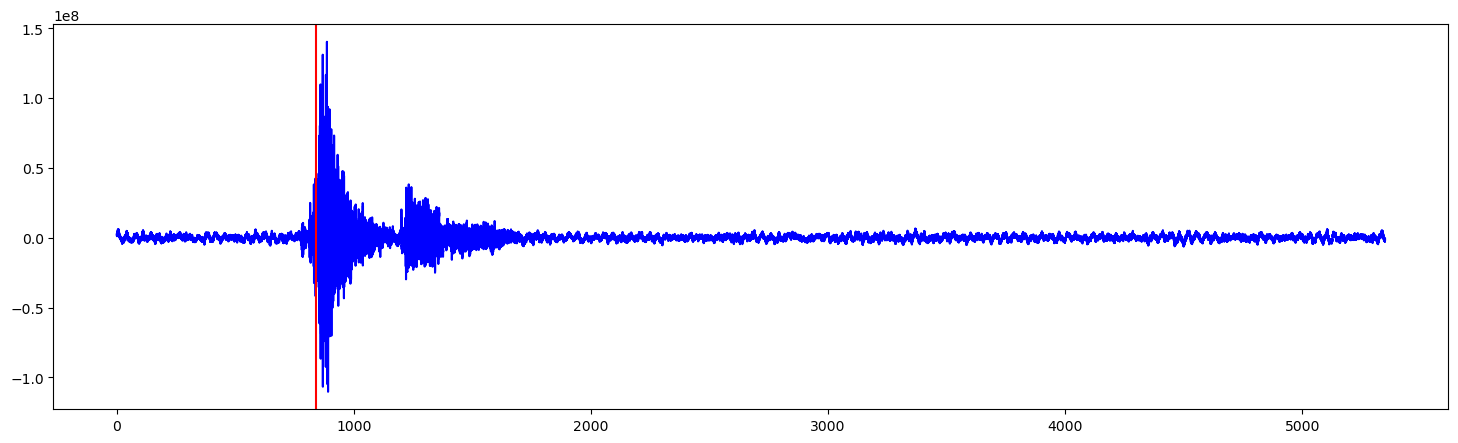

032whiteboard.wav


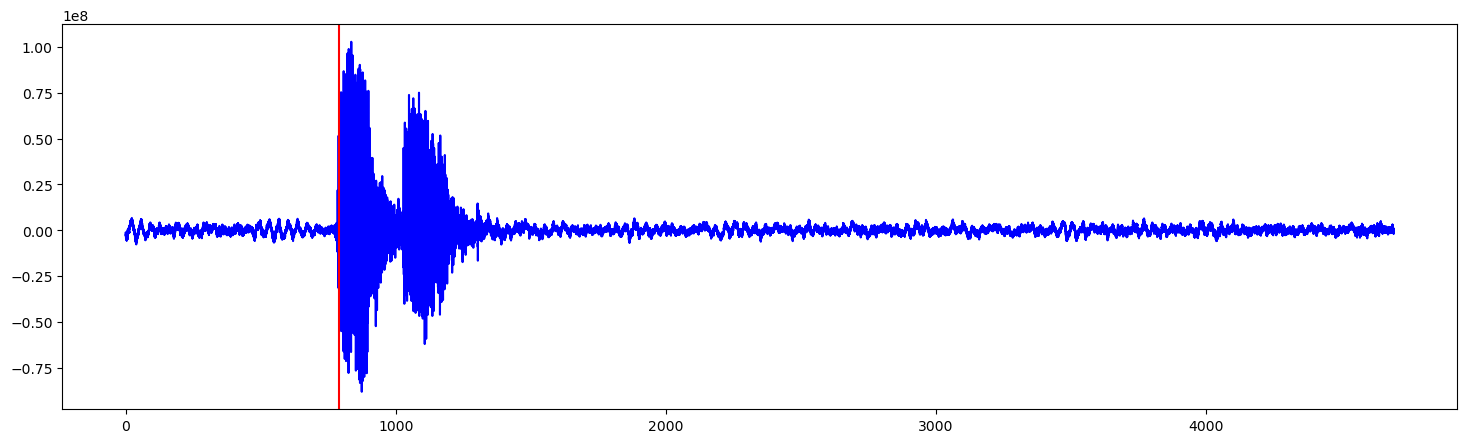

033toy.wav


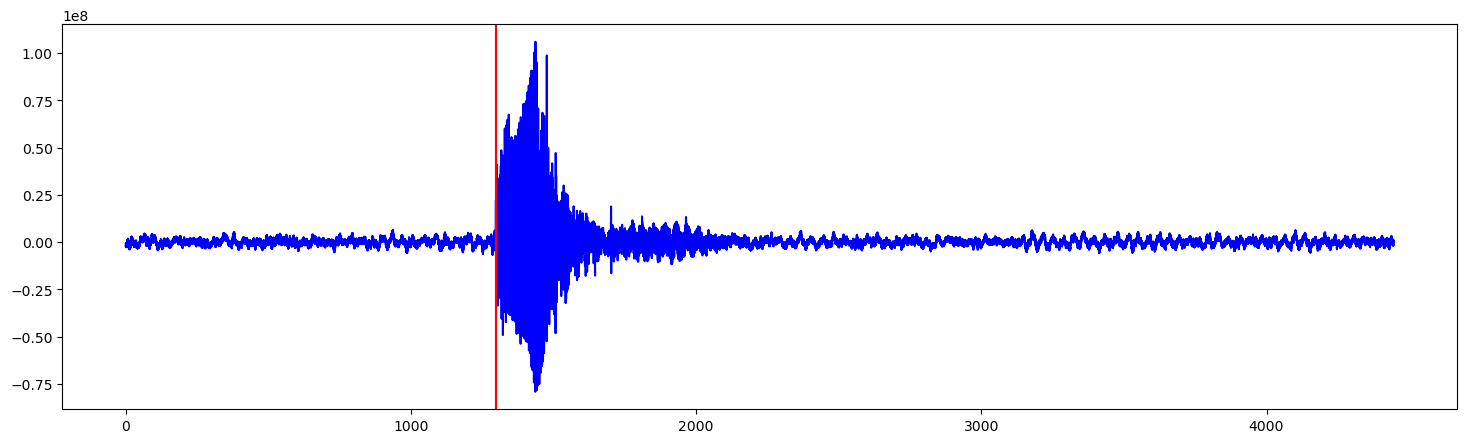

034parachute.wav


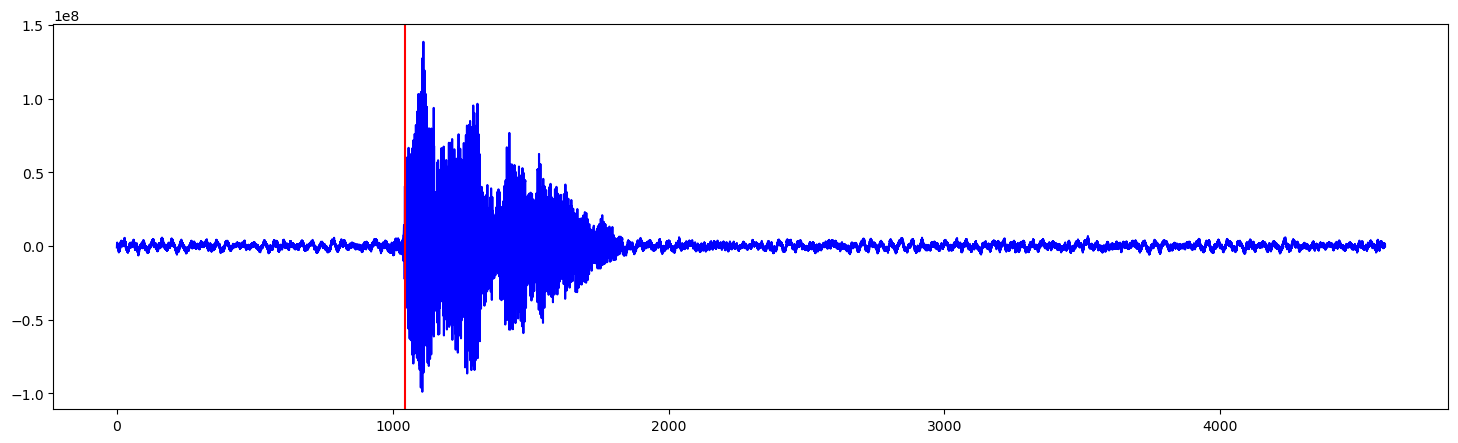

035bell.wav


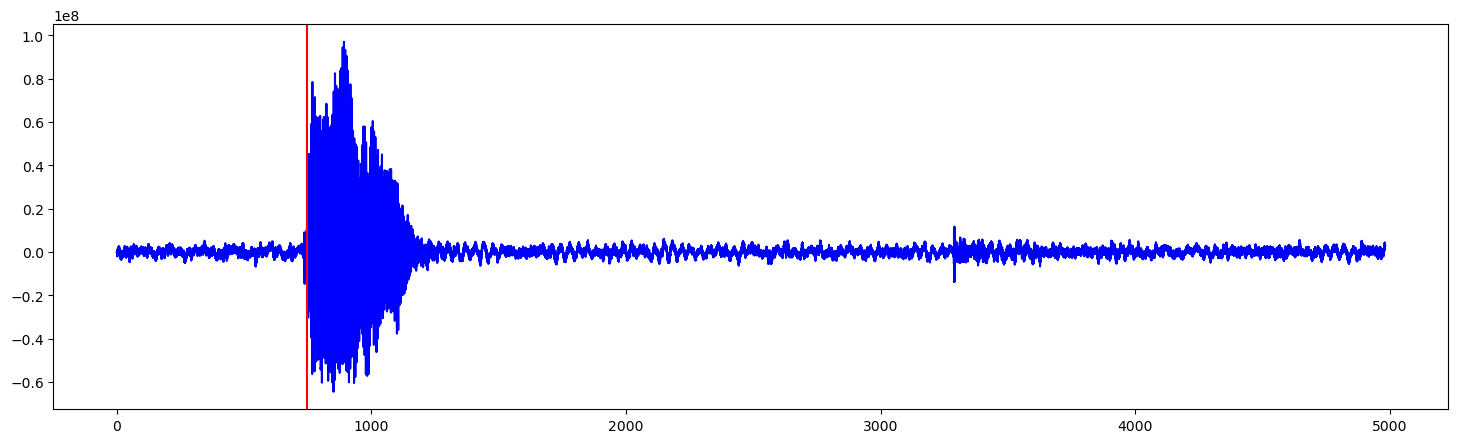

036icecube.wav


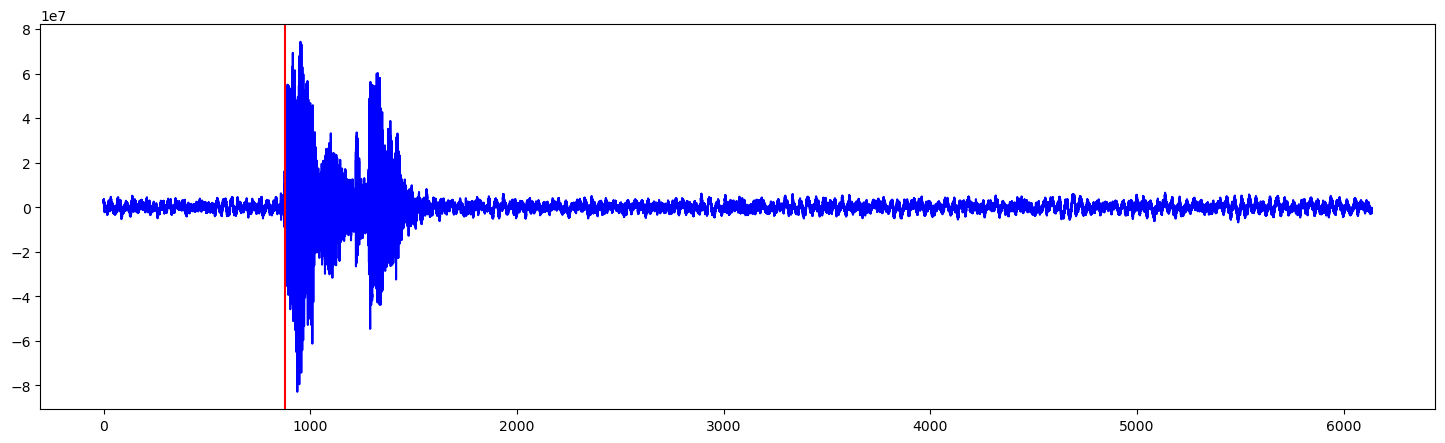

037taco.wav


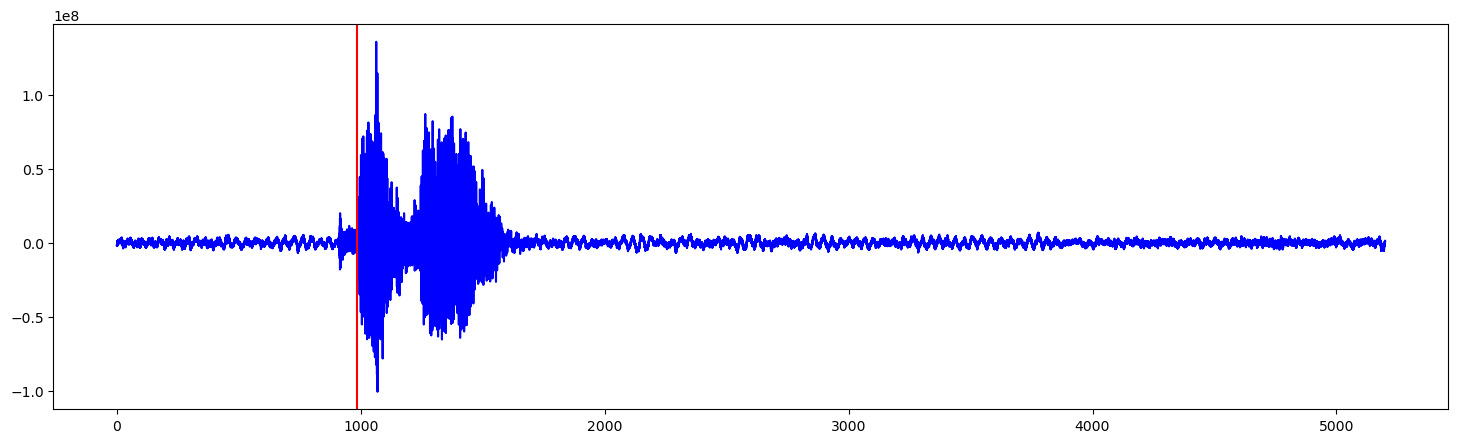

038cactus.wav


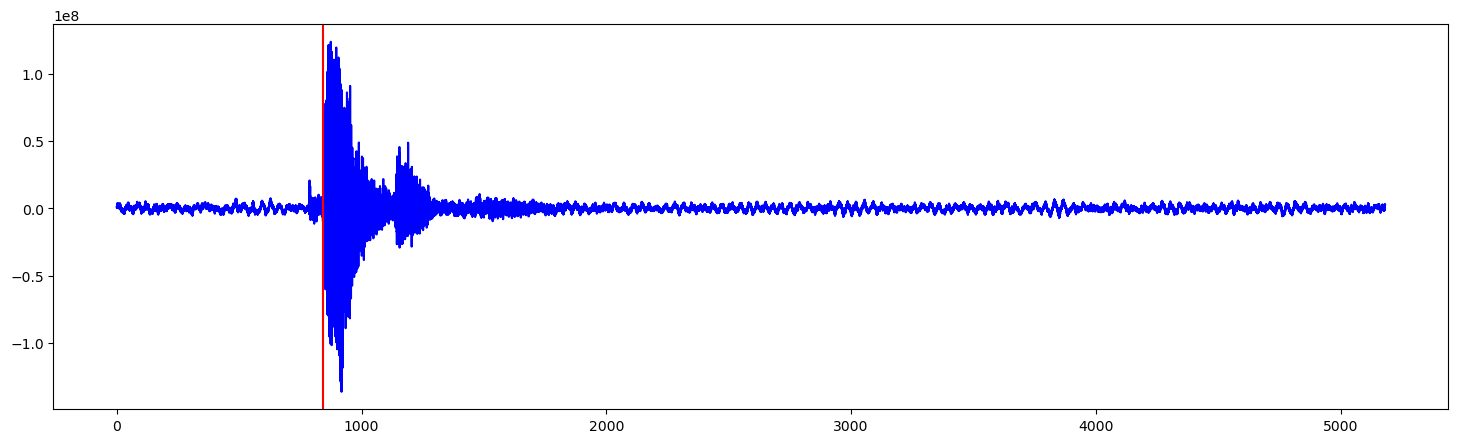

039dustpan.wav


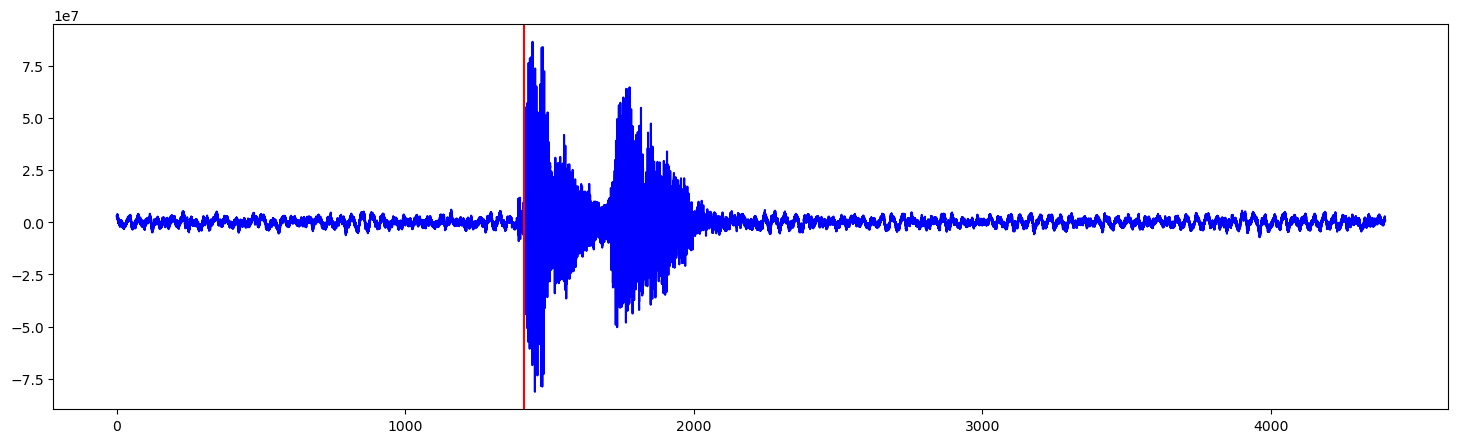

040collar.wav


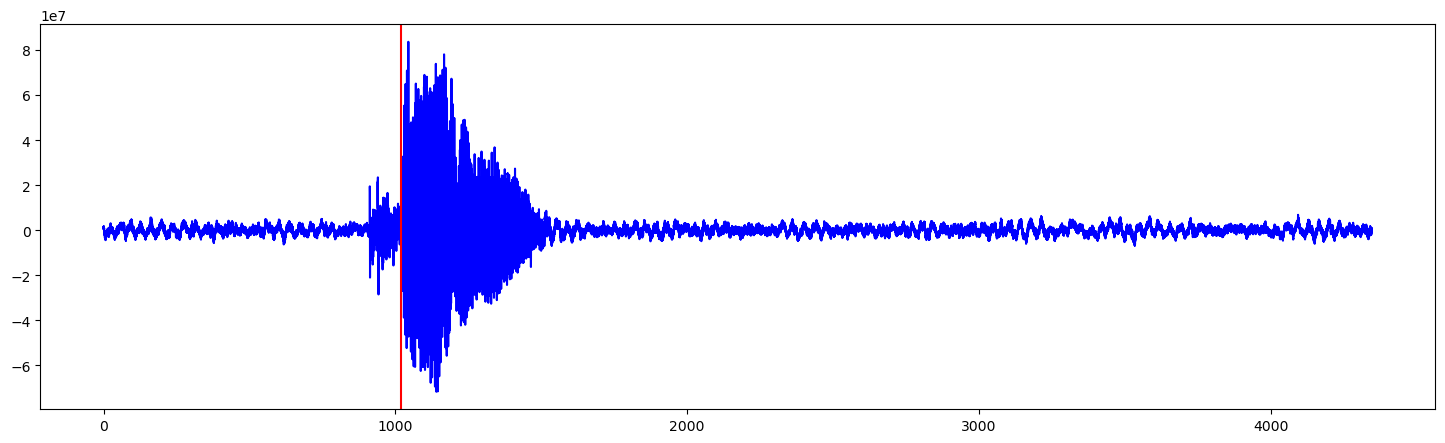

In [ ]:
folder_path = f"/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/{subject}/Recordings"

total, triggers, rep, no_rep = get_RTs(folder_path, word_list)

## Calculating Means

In [12]:
#Write to CSV
csv_file_path = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/Behavioral_Data/RTs_' + word_list + '.csv'
df = pd.read_csv(csv_file_path)

new_col = total
col_name = subject + ' RTs'
df[col_name] = new_col

# Step 4: Write the DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)